In [89]:
from time import time
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [90]:
# Read Data from Disk
data = pd.read_csv("../../steam_reviews.csv");


In [91]:
# Filter reviews with title
is_Rust = data['title'] == 'Rust'
data_rust = data[is_Rust];

In [92]:
tokens = []
for review in data_rust['review'].head():
    tokens.append(review.split());


In [93]:
# import multiprocessing
# cores = multiprocessing.cpu_count()
# print(cores)

# size: The number of dimensions of the embeddings and the default is 100.
# window: The maximum distance between a target word and words around the target word. The default window is 5.
# min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
# workers: The number of partitions during training and the default workers is 3.
# sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

model = Word2Vec(min_count=1, window=3, workers=3, sg=1)

In [94]:
# Building the Vocabulary Table
t = time()

model.build_vocab(tokens, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [95]:
model.train(tokens, total_examples=model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.0 mins


In [96]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



In [97]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

    # gets list of most similar words
    close_words = model.wv.most_similar([word])

    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)

    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)

    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})

    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)

    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )

    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for {}'.format(word.title()))

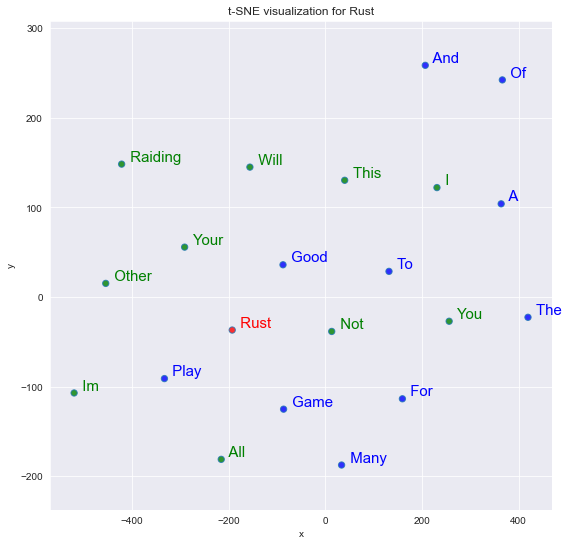

In [98]:
tsnescatterplot(model, 'rust',[t[0] for t in model.wv.most_similar(positive=["rust"], topn=20)][10:])